# ERCOT Load Model

*Adapted from Dr. David Chassin's Aggregate Building Load Model*

Olin Shipstead

## Importing data

In [1]:
from datetime import *
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re

,Load
timestamp,
2021-01-01 00:00:00,3545.093310
2021-01-01 01:00:00,3586.547882
2021-01-01 02:00:00,3586.124059
2021-01-01 03:00:00,3570.592369
2021-01-01 04:00:00,3590.902242


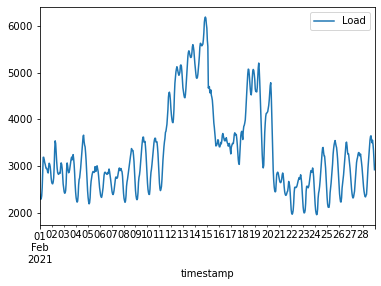

In [2]:
# ------ IMPORTING LOAD DATA --------- #
# Source: http://www.ercot.com/gridinfo/load/load_hist
# using ERCOT's Southern Load Zone

def fix_time(x):
    m, d, y, h, mn = map(int, re.findall('\d+', str(x["Hour Ending"])))
    return datetime(y,m,d,h-1,mn)

load = pd.read_excel("ERCOT_Native_Load_2021.xlsx")

load["timestamp"] = load.apply(fix_time, axis=1)
load = load.filter(["timestamp","SOUTH"]).rename(columns={"SOUTH":"Load"}).set_index("timestamp") # focusing on SOUTH as this is where we have solar data
load["2021-02-01":"2021-02-28"].plot();
load.head()

,Solar,Temp
2021-02-08 17:00:00,197.9478,26.6153
2021-02-08 18:00:00,58.8003,26.2997
2021-02-08 19:00:00,3.9165,25.4203
2021-02-08 20:00:00,0.0000,23.6561
2021-02-08 21:00:00,0.0000,23.1087


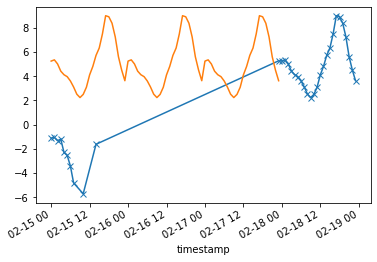

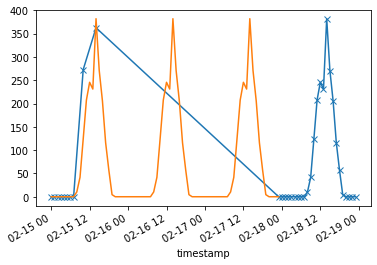

In [3]:
# ------ IMPORTING SOLAR+TEMP DATA ------ #
# Source: University of Texas Panamerican Solar Radiation Lab (https://midcdmz.nrel.gov/apps/daily.pl?site=UTPASRL&start=20110901&yr=2021&mo=11&dy=15)
# solar data is complete, but temp data only goes back to 02/08/2021
#! note - weather data complete from 02/08/2021 to mid-May 2021

weather = pd.read_csv("UT-PanAmerican_Solar_Temp.txt",sep=",", na_values=-99999).dropna()
weather["timestamp"] = weather.apply(lambda x: datetime.strptime(str(x["DATE (MM/DD/YYYY)"])+" "+str(x["HOUR-CST"]),"%m/%d/%Y %H"), axis=1)
weather = weather.filter(["timestamp","Avg Global Horizontal [W/m^2]","Avg Air Temperature [deg C]"])\
    .rename(columns={"Avg Global Horizontal [W/m^2]":"Solar","Avg Air Temperature [deg C]":"Temp"})\
    .set_index("timestamp")

weather["Solar"] = weather.apply(lambda x: 0 if x["Solar"]<0 else x["Solar"], axis=1) # clip solar at 0

#! problem: missing data
# 2021-02-15 07:00:00      0.0000
# 2021-02-15 10:00:00    272.9692
# 2021-02-15 14:00:00    362.6506
# 2021-02-17 23:00:00      0.0000 <-- no data from 2021-02-15 15:00:00 to 2021-02-17 22:00:00 (midday 15th-late 17th)
# 2021-02-18 00:00:00      0.0000

plt.figure(1)
weather.Temp["2021-02-15":"2021-02-18"].plot(marker="x")
plt.figure(2)
weather.Solar["2021-02-15":"2021-02-18"].plot(marker="x")

#! suggestion: duplicate 02-18 and use for 02-15, 02-16, 02-17
def impute_dates(x, date_to_copy, date_list):
    l = list(x["2021-02-15"].index)+list(x["2021-02-17"].index) # delete existing values for 02-15 and 02-17
    x = x.drop(l)
    for d in date_list:
        temp = pd.DataFrame(weather[date_to_copy])
        temp.index = pd.date_range(d, periods=24, freq="H") # create new date_times
        x = x.append(temp, verify_integrity=True)
    return x

weather = impute_dates(weather, "2021-02-18",["2021-02-15","2021-02-16","2021-02-17"])
plt.figure(1)
weather.Temp["2021-02-15":"2021-02-17"].plot(); # significantly lower on 15th than 18th
plt.figure(2)
weather.Solar["2021-02-15":"2021-02-17"].plot();
weather.head()

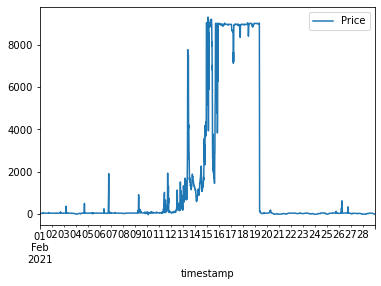

In [4]:
# ------ IMPORTING PRICE DATA ------ #
# Source: https://sa.ercot.com/misapp/GetReports.do?reportTypeId=13061&reportTitle=Historical%20RTM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey
# data represents Historical RTM Load Zone and Hub Prices

price = pd.read_excel("Feb21_LZ_SOUTH_Prices.xlsx", sheet_name="Feb")

price["timestamp"] = price.apply(lambda x: datetime.strptime(\
                                        str(x["Delivery Date"])+" "+\
                                        str(x["Delivery Hour"]-1)+":"+\
                                        str((x["Delivery Interval"]-1)*15),\
                                       "%m/%d/%Y %H:%M"),\
                                        axis=1)
price = price.filter(["timestamp","Settlement Point Price"])\
    .rename(columns={"Settlement Point Price":"Price"}).set_index("timestamp")
price["2021-02-01":"2021-02-28"].plot();
price.head();

## Merging and interpolating data to 15-min intervals

In [5]:
start = "2021-02-08 17:00:00" # constrained by weather (solar)
end = "2021-02-28 23:00:00"   # constrained by price
load_df = price.join(weather).join(load)[start:end].interpolate(method="linear") # interpolates solar, temp, load
print(f"Number of observations: {len(load_df)}")
load_df.head()

Number of observations: 1945


,Price,Solar,Temp,Load
timestamp,,,,
2021-02-08 17:00:00,20.25,197.947800,26.6153,3340.425916
2021-02-08 17:15:00,21.56,163.160925,26.5364,3338.721461
2021-02-08 17:30:00,23.94,128.374050,26.4575,3337.017006
2021-02-08 17:45:00,26.66,93.587175,26.3786,3335.312551
2021-02-08 18:00:00,27.69,58.800300,26.2997,3333.608096


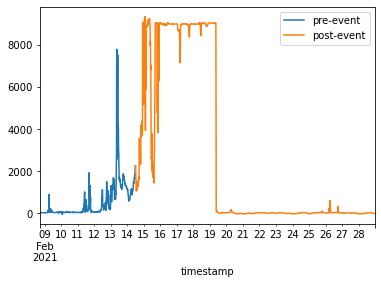

In [6]:
# define event timestamp to be midday 02-14
event = "02-14-2021 12:00:00"
load_df.Price[:event].plot(label="pre-event",legend=True)
load_df.Price[event:].plot(label="post-event",legend=True);

## Define transfer function

The $z$-domain transfer function from $T_O$ to $P$ can be written as
$$
    { P(z) \over T(z) } = { b_0 + b_1 z^{-1} + b_2 z^{-2} \over 1 + a_1 z^{-1} + a_2 z^{-2}+ a_3 z^{-3} }
$$
which gives us the relation
$$
    \mathbf{P}_{t} = 
        + b_2 \mathbf{T}_{t-2} 
        + b_1 \mathbf{T}_{t-1} 
        + b_0 \mathbf{T}_{t} 
        - a_3 \mathbf{P}_{t-3} 
        - a_2 \mathbf{P}_{t-2} 
        - a_1 \mathbf{P}_{t-1}
$$
where $t \in (4,K)$, and $\mathbf P$ and $\mathbf T \in \mathbb{R}^{K}$.

Given $K$ samples of power and temperature, this can be written in the form
$$
    \mathbf{M} \mathbf{x} = \mathbf{P}_{t}
$$
where $\mathbf{M} \in \mathbb{R}^{K-3\times6}$ with
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{P}_{t-3} & \mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} b_2 & b_1 & b_0 & -a_2 & -a_1 & -a_0 \end{matrix} \right]^T
$$
Solve for $\mathbf x$.
$$
    \mathbf{x} = (\mathbf{M}^T \mathbf{M})^{-1} \mathbf{M}^T \mathbf{P}_{t}.
$$

This solution can also be obtained efficiently using the Python SciPy `linalg.solve` function.


## Solve for transfer function coefficients

In [7]:
R = 3 # order of model 
K = len(load_df.Price) # num observations
N = len(load_df.Price[event:]) # observations to hold out

L = np.matrix(load_df.Load).transpose()  # load
T = np.matrix(load_df.Temp).transpose()  # temp
S = np.matrix(load_df.Solar).transpose() # solar
P = np.matrix(load_df.Price).transpose() # price

# construct M matrix
M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
            np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([P[n+1:K-R+n+1] for n in range(R)])])
print(M.shape)

Mh = M[0:-N] # leaving out last N observations
Mt = Mh.transpose()
x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,L[R:-N]))
Q = M[-N:]*x # predicted power output

(1942, 12)


## Visualize results

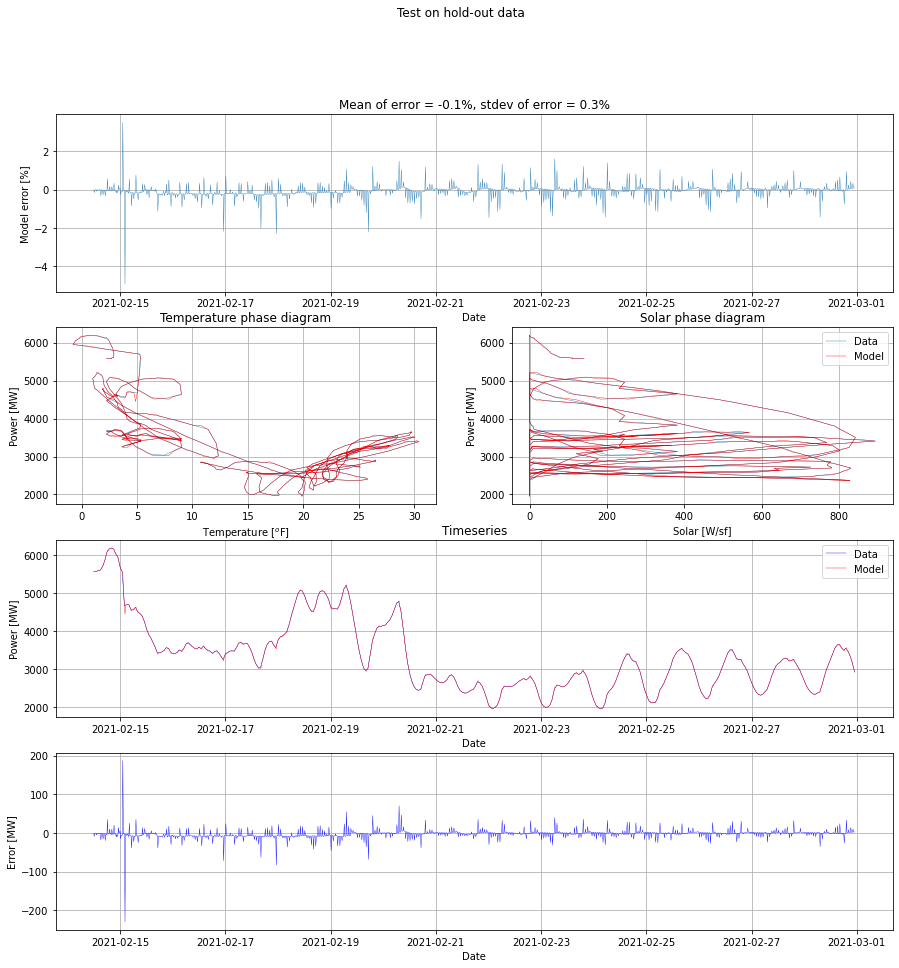

In [8]:
plt.figure(1,figsize=(15,15))

plt.suptitle(f"Test on hold-out data")

plt.subplot(411)
e = Q/L[-N:]-1 
t = load_df.index
plt.plot(t[-N:],e*100,linewidth=0.4) # errors are tiny...
plt.grid()
plt.xlabel("Date")
plt.ylabel("Model error [%]")
plt.title(f'Mean of error = {e.mean()*100:.1f}%, stdev of error = {e.std()*100:.1f}%')

plt.subplot(423)
plt.plot(T[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(T[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Temperature [$^o$F]')
plt.ylabel('Power [MW]')
plt.title("Temperature phase diagram")

plt.subplot(424)
plt.plot(S[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(S[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Solar [W/sf]')
plt.ylabel('Power [MW]')
plt.title("Solar phase diagram")
plt.legend()

plt.subplot(413)
plt.plot(t[-N:],L[-N:],'-b',linewidth=0.4,label="Data")
plt.plot(t[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Date')
plt.ylabel('Power [MW]')
plt.legend()
plt.title("Timeseries");

plt.subplot(414)
plt.plot(t[-N:],Q[-N:] - L[-N:],"-b",linewidth=0.4)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Error [MW]');

## Battery optimization

- battery storage = 5 kWh and battery power = 1 kW
- inter-temporal battery efficiency = 100%
- the round-trip efficiency = 95% (on charging)  
- minimum charge = 1kWh (20%)
- market runs per hour = 4 [hr^-1]

In [9]:
import cvxpy as cp

In [10]:
# Initialize variables
s = cp.Variable((K+1,)) # state of charge (kWh)
x_d = cp.Variable((K,)) # discharging dispatches (kW)
x_c = cp.Variable((K,)) # charging dispatches (kW)

# Initialize constraints
constraints = [s[0]==2.]
constraints += [s[K]==2.]

# Append physical constraints for all t
for t in range(K):
    constraints += [x_d[t]<=1., x_d[t]>=0.,
                    x_c[t]<=1., x_c[t]>=0.,
                    s[t]>=1., s[t]<=5., 
                    s[t+1]==1.00*s[t] + 0.95*x_c[t]/4 - x_d[t]/4 ] # kWh = kWh + kW/(1/hr) - kW/(1/hr)
    
# Objective function
obj = cp.Maximize(cp.sum(cp.multiply(load_df.Price/1000,(x_d-x_c)/4))) # $/kWh * (kW-kW)/(1/hr) = $/kWh * kWh = $

In [11]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = prob.solve()

In [12]:
print("Optimal profits: ${0:.2f}".format(profits))

Optimal profits: $106.79


## Visualization

<ipython-input-13-b40e1bc2a89c>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


Text(0, 0.5, 'Profits (USD)')

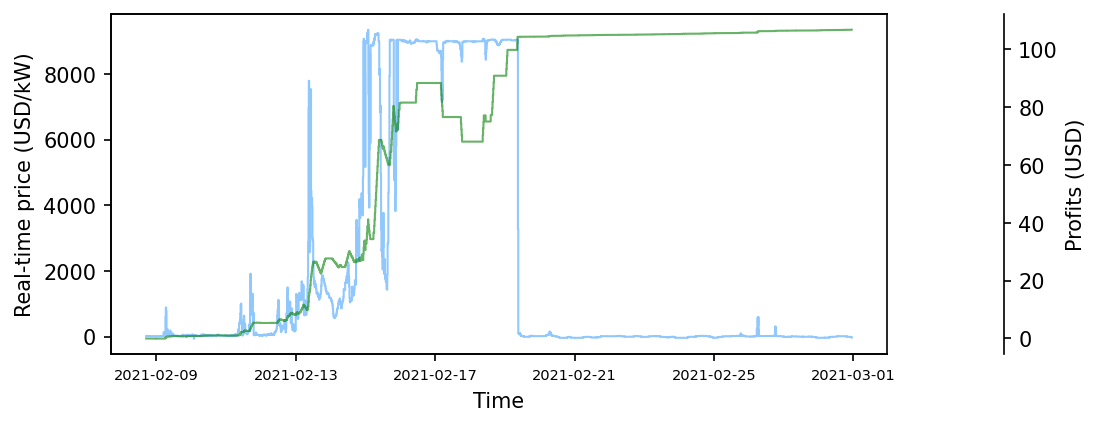

In [13]:
fig = plt.figure(figsize=(9,3),dpi=150) 

ax = fig.add_subplot(111)
plot1 = ax.step(load_df.index, load_df.Price, alpha=0.8, linewidth=1, where="post", color='xkcd:sky blue', label='RT')
ax.set_xlabel('Time')
ax.set_ylabel('Real-time price (USD/kW)')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)

# ax2 = ax.twinx()
# plot2 = ax2.step(load_df.index, s.value[:-1], alpha=0.6, linewidth=1, where="post", color='orange', label='SOC')
# ax2.set_ylabel('State of Charge (kWh)')

ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.15))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

cum_profits = np.cumsum(-(x_c.value-x_d.value)*load_df.Price/1000)/4
plot3 = ax3.step(load_df.index, cum_profits, alpha=0.6, linewidth=1, where="post", color='green', label='Profits')
ax3.set_ylabel("Profits (USD)")

# plots = plot1 + plot2 + plot3
# labs = [l.get_label() for l in plots]
# L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

Text(0, 0.5, 'Real-time price (USD/MWh)')

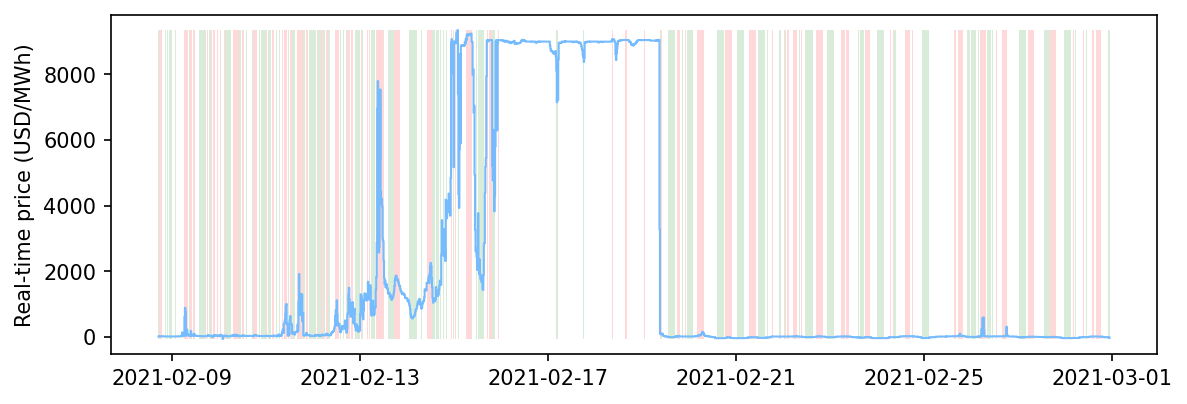

In [14]:
results_df = pd.DataFrame({"s":s[:-1].value,"P_t":load_df.Price,"x_c":x_c.value,"x_d":x_d.value})
day = results_df

fig = plt.figure(figsize=(9,3),dpi=150)

ax = fig.add_subplot(111)
ax.fill_between(day.index,max(day["P_t"]), min(day["P_t"]), where = (day["x_c"]>0.001)&(day["x_d"]<0.001), facecolor='green', alpha=0.15)
ax.fill_between(day.index,max(day["P_t"]), min(day["P_t"]), where = (day["x_d"]>0.001)&(day["x_c"]<0.001), facecolor='red', alpha=0.15)

plot1 = ax.step(day.index, day["P_t"], linewidth=1, where="post", color='xkcd:sky blue', label='RT')
ax.set_ylabel('Real-time price (USD/MWh)')

# ax2 = ax.twinx()
# plot2 = ax2.step(day.index, day["s"], linewidth=1, where="post", color='orange', label='SOC')
# ax2.set_ylabel('State of Charge (kWh)')

# plots = plot2 + plot1
# labs = [l.get_label() for l in plots]
# ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs));

## Update load and test model

In [15]:
num_batteries = 10000
load_df["UpdatedLoad"] = load_df.Load + (x_c.value-x_d.value)/1000 * num_batteries # x_c-x_d capped at 1 kW

In [16]:
L = np.matrix(load_df.UpdatedLoad).transpose()  # load

# construct M matrix
M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
            np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([P[n+1:K-R+n+1] for n in range(R)])])
print(M.shape)

# Mh = M[0:-N] # leaving out last N observations
# Mt = Mh.transpose()
# x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,L[R:-N]))

Q = M[-N:]*x # predicted power output

(1942, 12)


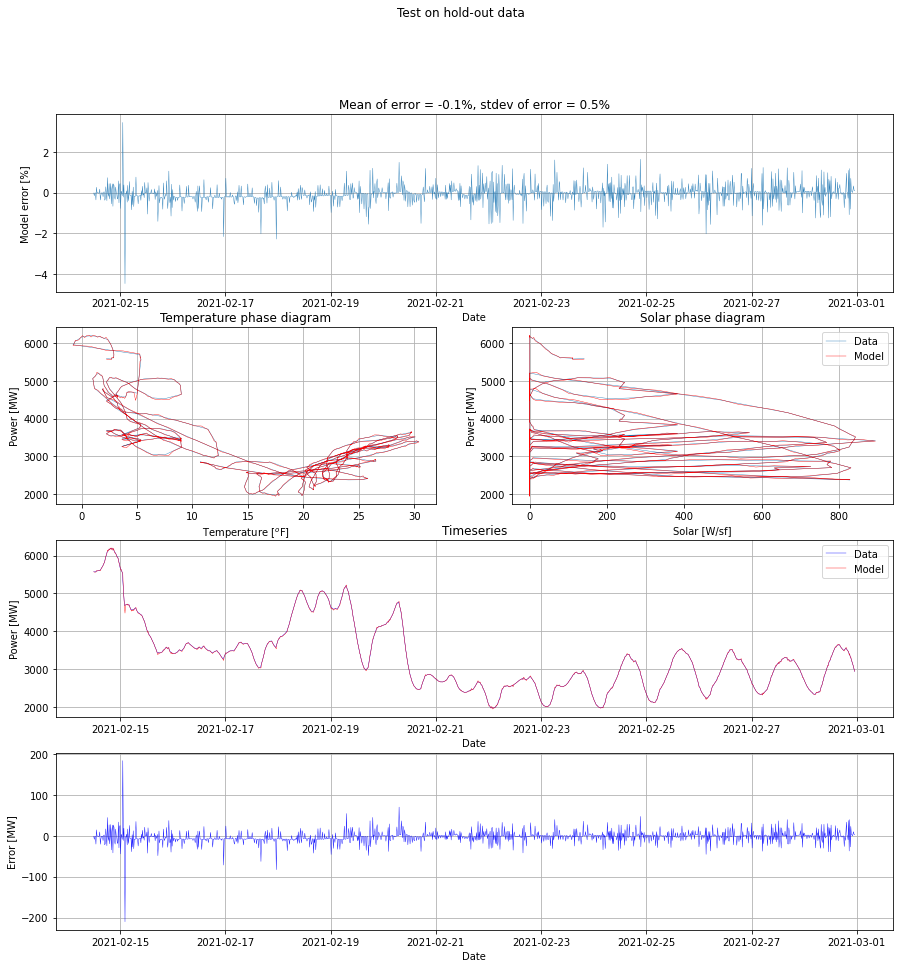

In [17]:
plt.figure(1,figsize=(15,15))

plt.suptitle(f"Test on hold-out data")

plt.subplot(411)
e = Q/L[-N:]-1 
t = load_df.index
plt.plot(t[-N:],e*100,linewidth=0.4) # errors are tiny...
plt.grid()
plt.xlabel("Date")
plt.ylabel("Model error [%]")
plt.title(f'Mean of error = {e.mean()*100:.1f}%, stdev of error = {e.std()*100:.1f}%')

plt.subplot(423)
plt.plot(T[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(T[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Temperature [$^o$F]')
plt.ylabel('Power [MW]')
plt.title("Temperature phase diagram")

plt.subplot(424)
plt.plot(S[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(S[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Solar [W/sf]')
plt.ylabel('Power [MW]')
plt.title("Solar phase diagram")
plt.legend()

plt.subplot(413)
plt.plot(t[-N:],L[-N:],'-b',linewidth=0.4,label="Data")
plt.plot(t[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Date')
plt.ylabel('Power [MW]')
plt.legend()
plt.title("Timeseries");

plt.subplot(414)
plt.plot(t[-N:],Q[-N:] - L[-N:],"-b",linewidth=0.4)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Error [MW]');